<a href="https://colab.research.google.com/github/EugenHotaj/pytorch-generative/blob/master/notebooks/__draft__bayesian_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://www.github.com/EugenHotaj/pytorch-generative pytorch-generative 
!mv pytorch-generative/pytorch_generative .
%load_ext tensorboard

Cloning into 'pytorch-generative'...
remote: Enumerating objects: 1297, done.
remote: Counting objects: 100% (542/542), done.
remote: Compressing objects: 100% (422/422), done.
remote: Total 1297 (delta 377), reused 236 (delta 119), pack-reused 755
Receiving objects: 100% (1297/1297), 38.93 MiB | 25.92 MiB/s, done.
Resolving deltas: 100% (880/880), done.


In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from torch import distributions
from scipy import linalg, spatial

from pytorch_generative.models import base

In [3]:
def sausage_plot(X, Y=None, mu_sig=None, fn=None, obs=None):
    """Creates a sausage plot of a 1D Gaussian process. 

    Args:
        X: (n x 1) array containing the x-axis coordinates.
        Y: (n x k) array containing k samples drawn from the Gaussian process at X.
        mu_sig: Tuple of (n x 1) arrays containing the marginal (means, stds) at X. If
            provided the means and 95% credible intervals are plotted.
        fn: True (noiseless) function being modeled by the Gaussian process. If 
            provided, fn(X) is plotted.
        obs: Tuple of (possibly noisy) observations from the true function.
    """
    assert any([Y is not None, mu_sig is not None, fn is not None])

    def detach(x):
        if torch.is_tensor(x):
            return x.detach()
        return x

    X = detach(X).squeeze()
    fig = plt.figure(figsize=(20, 4))
    y_max = []
 
    # Plot samples.
    if Y is not None:
        Y = detach(Y)
        for i in range(Y.shape[0]): 
            sample = Y[i, :]
            plt.plot(X, sample, color="tab:orange")
            y_max.append(sample)

    # Plot mean and credible intervals.
    if mu_sig is not None:
        mu, sigma = detach(mu_sig[0]), detach(mu_sig[1])
        lower_bound, upper_bound = mu - 1.96 * sigma, mu + 1.96 * sigma
        plt.fill_between(X, lower_bound, upper_bound, facecolor='lightblue')
        plt.plot(X, mu, c="tab:blue")
        y_max.extend([lower_bound, upper_bound, mu])

    # Plot the true function.
    if fn is not None:
        Y = fn(X)
        plt.plot(X, Y, color="tab:red", linestyle="dashed")
        y_max.append(Y)

    # Plot observations.
    if obs is not None:
        obs_x, obs_y = detach(obs[0]), detach(obs[1])
        plt.scatter(obs_x[:-1], obs_y[:-1], color="tab:red", marker="x", s=128)
        plt.scatter(obs_x[-1], obs_y[-1], color="tab:green", marker="x", s=128)
        y_max.append(obs_y)

    # Set axis limits.
    plt.xlim(X.min(), X.max())
    y_max = max([np.abs(y).max() for y in y_max])
    plt.ylim(-y_max - .5, y_max + .5)

### Gaussian Processes

In [4]:
class SquaredExponential(nn.Module):
    def __init__(self, std=None, lengthscale=None):
        super().__init__()
        self.std = std or nn.Parameter(torch.tensor(1.0))
        self.lengthscale = lengthscale or nn.Parameter(torch.tensor(1.0))

    def forward(self, left, right):
        d = torch.cdist(left, right) / self.lengthscale
        return self.std**2 * torch.exp(-.5 * d**2)

class Const(nn.Module):
    def __init__(self, value=None):
        super().__init__()
        self.value = value or nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        return torch.ones(x.shape[0], 1) * self.value


class GaussianProcess(base.GenerativeModel):
    """The Gaussian process model."""

    def __init__(self, mean, kernel, noise_var=None):
        """Initializes a new GaussianProcess.
        Args:
            mean: Prior mean function mu(x).
            kernel: Prior covariance function K(x, x').
            noise_var: The variance of the observation noise. If not provided,
                observation noise is learned from the training data.
        """
        super().__init__()
        self.mean = mean
        self.kernel = kernel
        self.noise_var = noise_var or nn.Parameter(torch.tensor(0.0))
        self.train_x = None
        self.train_y = None

    def fit(self, x, y):
        """Fits the Gaussian process on the given training data."""
        if self.train_x is None:
            self.train_x, self.train_y = x, y
        else:
            self.train_x = torch.cat([self.train_x, x])
            self.train_y = torch.cat([self.train_y, y])

    # TODO(eugenhotaj): Figure out why PyTorch claims the covariance matrix is not
    # positive semidefinite.
    def sample(self, x, n_samples):
        """Samples n_samples from the Gaussian process at the given location.
        The samples are drawn from the posterior if `fit()` has already been called,
        otherwise the samples are drawn from the prior.
        Args:
            x: The location to sample at.
            n_samples: The number of samples to return.
        Returns:
            The samples.
        """
        with torch.no_grad():
            mu, sig = self.predict(x)
            mu, sig = mu.numpy(), sig.numpy()
        sample = np.random.multivariate_normal(mu.squeeze(), sig, size=(n_samples,))
        return torch.tensor(sample)

    def predict(self, x):
        """Computes the predicted means and variances at the given location.
        The posterior means and variances are returned if `fit()` has already been
        called otherwise the prior means and variances are returned.
        Args:
            x: The location to predict at.
        Returns
            The predicted means and variances.
        """
        if self.train_x is None:
            return self.mean(x), self.kernel(x, x)

        # Compute means and covariances.
        train_mu, x_mu = self.mean(self.train_x), self.mean(x)
        train_sig = self.kernel(
            self.train_x, self.train_x
        ) + self.noise_var * torch.eye(self.train_x.shape[0])
        x_sig, cross_sig = self.kernel(x, x), self.kernel(self.train_x, x)

        # Compute posterior mean and covariance.
        solved = torch.linalg.solve(train_sig, cross_sig).T
        mu = x_mu + solved @ (self.train_y - train_mu)
        sig = x_sig - (solved @ cross_sig)

        return mu, sig

In [5]:
domain = 0, 6
n_grid = 100
n_train = 5
n_dim = 1
n_samples = 4
noise_std = 0.1

def f(x, noise=0.):
    x = x.view(x.shape[0], -1)
    y = torch.sin(x).sum(axis=1, keepdims=True)
    if noise:
        y += torch.randn(size=y.shape) * noise
    return y

train_x = torch.rand(n_train, n_dim, dtype=torch.float64) * domain[1]
train_y = f(train_x, noise_std)
grid_x = torch.cartesian_prod(
    *(
        torch.linspace(domain[0], domain[1], n_grid, dtype=torch.float64)
        for _ in range(n_dim)
    )
).view(-1, n_dim)

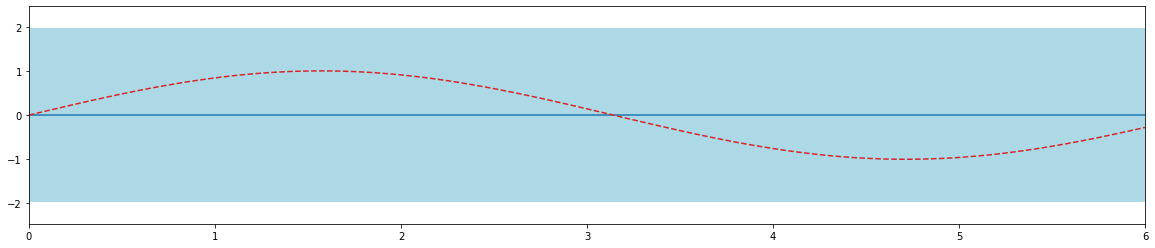

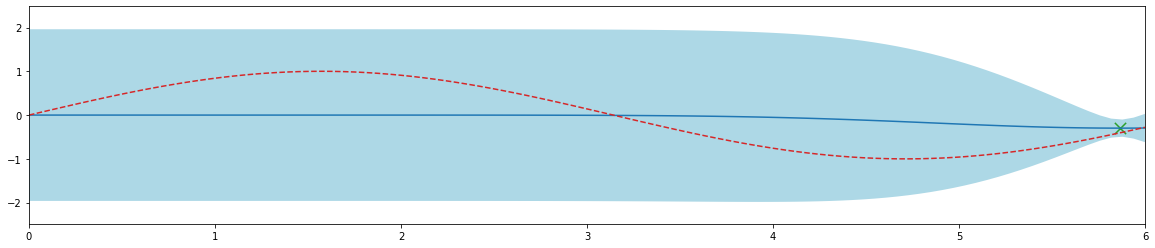

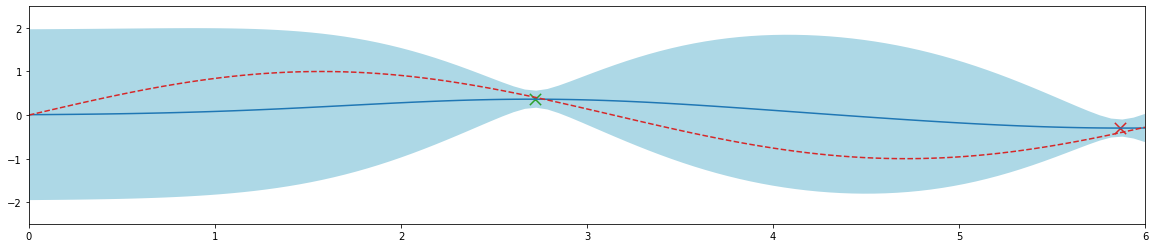

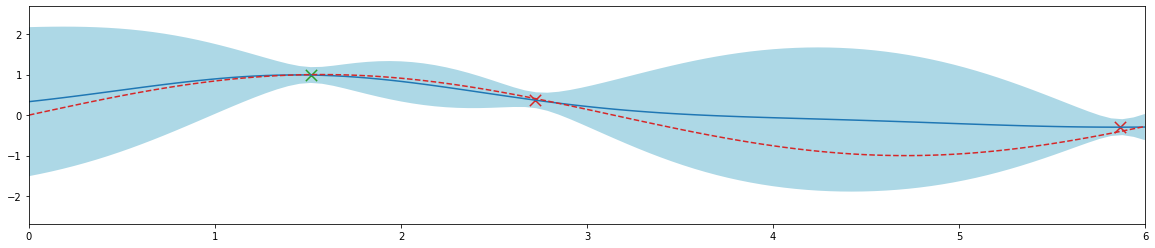

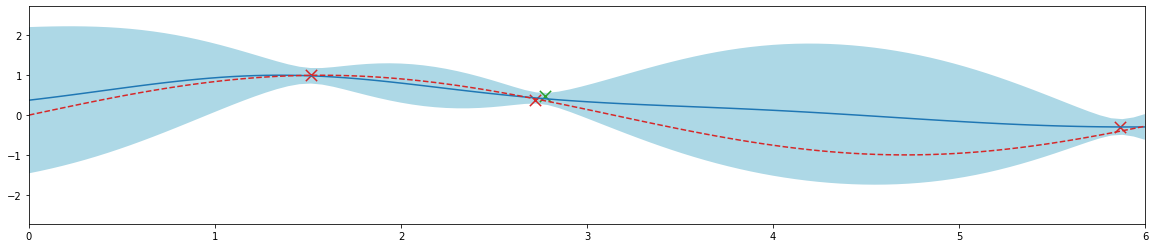

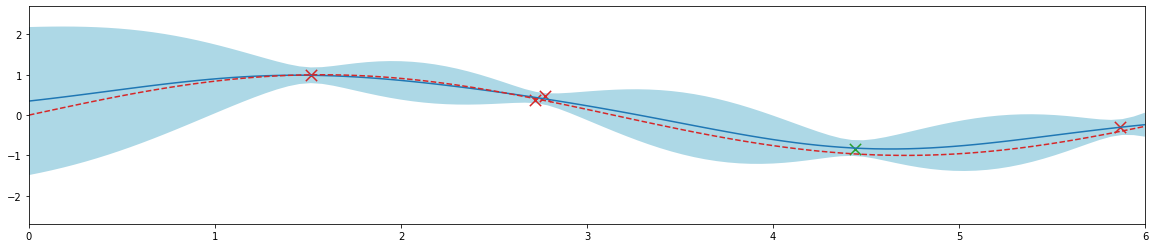

In [6]:
gp = GaussianProcess(Const(), SquaredExponential(), noise_std**2)

# Sample from prior.
mu, sigma = gp.predict(grid_x)
sausage_plot(
    X=grid_x,
    Y=None, 
    mu_sig=(mu.squeeze(), torch.sqrt(torch.diag(sigma))), 
    fn=f,
)

# Sample from posterior.
for i in range(len(train_x)):
    gp.fit(train_x[i:i+1], train_y[i:i+1])
    mu, sigma = gp.predict(grid_x)
    sausage_plot(
        X=grid_x, 
        Y=None, 
        mu_sig=(mu.squeeze(), torch.sqrt(torch.diag(sigma))), 
        fn=f, 
        obs=(train_x[:(i+1)], train_y[:(i+1)]),
    )

# Acquisition functions

In [7]:
# Expected improvement.
def expected_improvement(model, x, previous_best):
    """Computes the Expected Improvement over previous_best at the given location.
    
    Expected Improvement is defined as E_{y ~ model(x)}[max(0, y - previous_best)].

    Args:
        TODO
    Returns:
        TODO
    """
    mu, sig = model.predict(x)    
    improvement = mu - previous_best
    scaled_improvement = improvement / sig
    y = distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))
    return improvement * y.cdf(scaled_improvement) + sig * y.log_prob(scaled_improvement).exp()


### Bayeisan Optimization via Thompson Sampling 

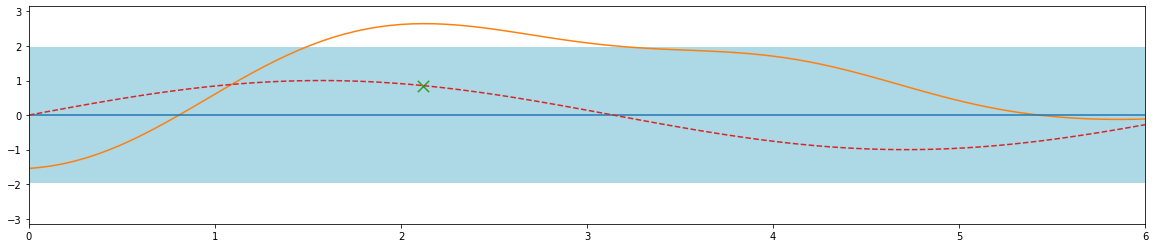

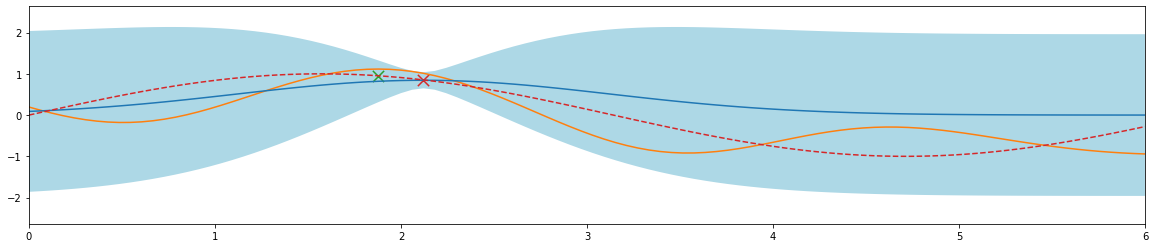

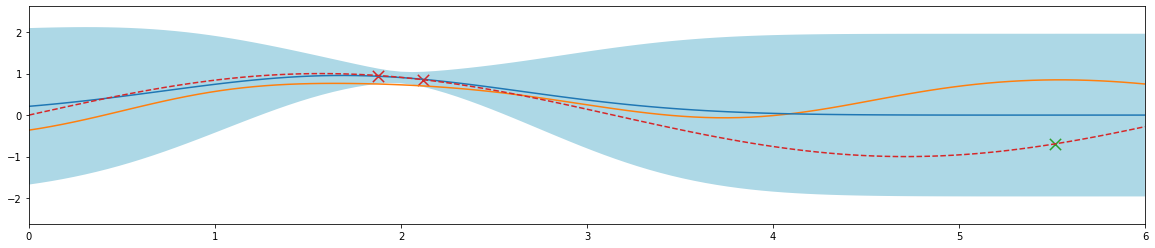

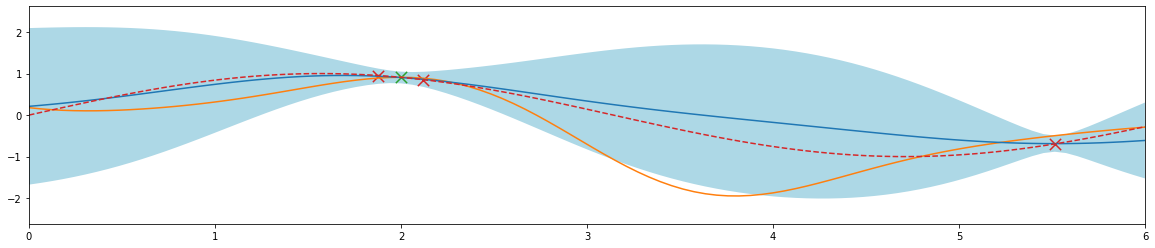

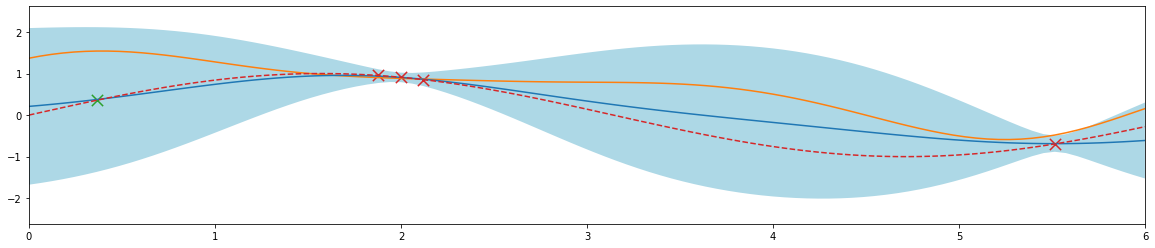

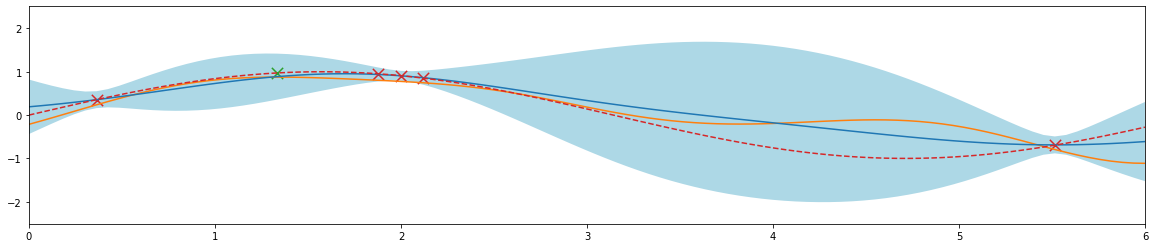

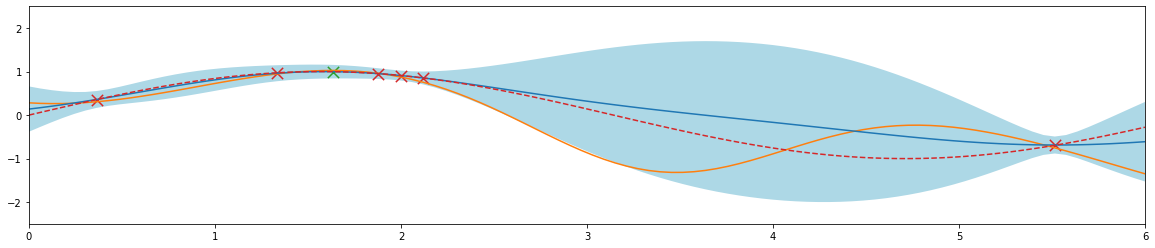

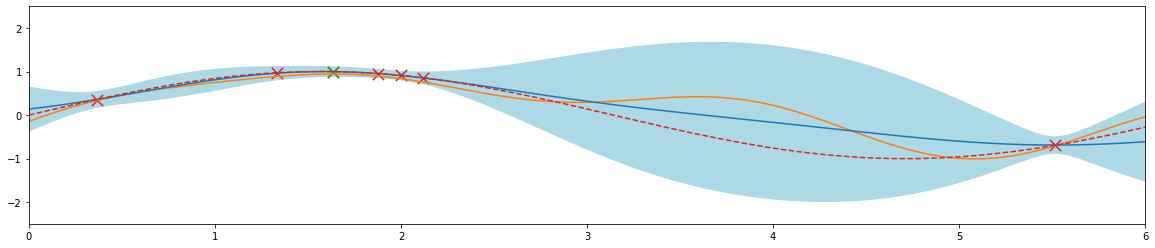

In [8]:
train_x, train_y = [], []
gp = GaussianProcess(Const(), SquaredExponential(), noise_std**2)
for i in range(8):
    # Get Thompson sample and maximize.
    mu, sigma, = gp.predict(grid_x)
    sample = gp.sample(grid_x, n_samples=1)
    max_idx = torch.argmax(sample)
    max_x = grid_x[max_idx.item():max_idx.item()+1]
    max_y = f(max_x).view(1, -1)

    # Fit GP for next round.
    train_x.append(max_x)
    train_y.append(max_y)
    gp.fit(max_x, max_y)

    # Plot round.
    sausage_plot(
        X=grid_x, 
        Y=sample, 
        mu_sig=(mu.squeeze(), torch.sqrt(torch.diag(sigma))), 
        fn=f, 
        obs=(train_x, train_y),
    )